Import libraries

In [81]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch, re
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(42)
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix, top_k_accuracy_score
)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


Read data

In [82]:
folder_path = "/home/zebborjesson/Documents/school/tra300_digitalization_in_sports/tra300-ski-technique-classification/data_sync/outputs"

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and "NR" in f]

dataframes = {}
for file in csv_files:
    full_path = os.path.join(folder_path, file)
    df = pd.read_csv(full_path)
    dataframes[file] = df


In [83]:
# ==== CONFIG ====
# Name of ONE CSV (from dataframes keys) to use as TEST set.
# Leave as None to automatically pick the first one alphabetically.
TEST_FILE = "BIA24-2_NR_merged_with_gear.csv"

# If you already know your columns, set them; otherwise, leave as None to auto-guess.
# Example:
# input_cols = ["feat1", "feat2", "feat3"]
# output_cols = ["label"]
input_cols = ["speed_kmph", "power_w", "frequency_ppm", "thrust_left_ms", "thrust_right_ms", "impulse_left_ns", "impulse_right_ns", "force_meanl_n", "force_meanr_n", "f_tot_mean_n"]
output_cols = ["Gear"]

# ==== PREVIEW FILES ====
print("Loaded CSV files:")
for k in sorted(dataframes.keys()):
    print(" •", k)

# Take a sample frame to list columns
_sample_key = next(iter(dataframes))
print("\nColumns in sample file:", _sample_key)
print(list(dataframes[_sample_key].columns))

# Simple auto-guess if user didn't specify:
if input_cols is None or output_cols is None:
    cols = list(dataframes[_sample_key].columns)
    lower = [c.lower() for c in cols]
    guess_y = None
    for cand in ["label", "target", "y", "class"]:
        if cand in lower:
            guess_y = cols[lower.index(cand)]
            break
    if guess_y is None:
        guess_y = next((c for c in cols if c.lower().endswith("_y") or "target" in c.lower()), None)
    if guess_y is None:
        guess_y = cols[-1]  # fallback: last column

    numeric_cols = [c for c in cols if pd.api.types.is_numeric_dtype(dataframes[_sample_key][c])]
    input_cols = [c for c in numeric_cols if c != guess_y]
    output_cols = [guess_y]

print("\nUsing inputs:", input_cols)
print("Using output:", output_cols)

# Choose TEST file
if TEST_FILE is None:
    TEST_FILE = sorted(dataframes.keys())[0]
print("\nTest file:", TEST_FILE)


Loaded CSV files:
 • BIA24-18_NR_merged_with_gear.csv
 • BIA24-19_NR_merged_with_gear.csv
 • BIA24-20_NR_merged_with_gear.csv
 • BIA24-22_NR_merged_with_gear.csv
 • BIA24-2_NR_merged_with_gear.csv
 • BIA24-3_NR_merged_with_gear.csv
 • BIA24-4_NR_merged_with_gear.csv
 • BIA24-5_NR_merged_with_gear.csv
 • BIA24-7_NR_merged_with_gear.csv
 • BIA24-8_NR_merged_with_gear.csv
 • BIA24-9_NR_merged_with_gear.csv

Columns in sample file: BIA24-20_NR_merged_with_gear.csv
['sessionid', 'tt_s', 'distance_m', 'slope_pct', 'speed_kmph', 'power_w', 'heartrate_bpm', 'frequency_ppm', 'cycle', 'thrust_left_ms', 'thrust_right_ms', 'impulse_left_ns', 'impulse_right_ns', 'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n', 'treadmill_force_n', 'altitude_m', 'latitude_deg', 'longitude_deg', 'usernote = BIA24-20NR', 'Sport', 'ns1:Id', 'StartTime', 'ns1:TotalTimeSeconds', 'ns1:DistanceMeters', 'ns1:MaximumSpeed', 'ns1:Calories', 'ns1:Value', 'ns1:Value2', 'ns1:Intensity', 'ns1:TriggerMethod', 'ns1:Time', 'ns1:Alt

In [84]:
# ---- Split into train/test files ----
train_keys = [k for k in dataframes.keys() if k != TEST_FILE]
test_key = TEST_FILE

train_df_full = pd.concat([dataframes[k] for k in train_keys], ignore_index=True) # Renamed
test_df = dataframes[test_key].copy()

needed_cols = list(set(input_cols + output_cols))
train_df_full = train_df_full.dropna(subset=needed_cols).reset_index(drop=True)
test_df = test_df.dropna(subset=needed_cols).reset_index(drop=True)

# ---- Normalize labels: "2.0H" / "2.0V" / "2.0" -> "2.0" ----
label_col = output_cols[0]

def normalize_label(val: object) -> str:
    s = str(val).strip()
    m = re.search(r'^-?\d+(?:\.\d+)?', s) # take leading number (int or float)
    if m:
        return f"{float(m.group(0)):.1f}" # standardize format, e.g., 2 -> "2.0"
    return s # fall back to original string

train_df_full[label_col] = train_df_full[label_col].apply(normalize_label)
test_df[label_col] = test_df[label_col].apply(normalize_label)

# ==== NEW: Create Train/Validation Split ====
# We split the full training data into a new (smaller) training set
# and a validation set.
try:
    train_df, val_df = train_test_split(
        train_df_full,
        test_size=0.2, # 20% for validation
        random_state=42,
        stratify=train_df_full[label_col] # Keep class distribution in splits
    )
except ValueError:
    print("Warning: Could not stratify split (likely due to rare classes). Splitting without stratification.")
    train_df, val_df = train_test_split(
        train_df_full,
        test_size=0.2, # 20% for validation
        random_state=42
    )

# ---- Encode labels using ALL labels (train_full + test) to avoid unseen-label errors ----
label_encoder = LabelEncoder()
all_labels = pd.concat(
    [train_df_full[label_col], test_df[label_col]], # Use train_df_full here
    ignore_index=True
)
label_encoder.fit(all_labels)

y_train = label_encoder.transform(train_df[label_col]) # Use new train_df
y_val = label_encoder.transform(val_df[label_col])     # Create y_val
y_test = label_encoder.transform(test_df[label_col])
num_classes = len(label_encoder.classes_)

# Warn if any class exists only in test
train_classes = set(np.unique(y_train))
val_classes = set(np.unique(y_val))
test_classes = set(np.unique(y_test))

only_in_test = sorted(list(test_classes - train_classes - val_classes))
if only_in_test:
    names_only_in_test = [label_encoder.classes_[i] for i in only_in_test]
    print("⚠️ These classes exist only in TEST (not seen in train/val):", names_only_in_test)

# ---- Prepare inputs ----
X_train = train_df[input_cols].values.astype(np.float32)
X_val = val_df[input_cols].values.astype(np.float32)     # Create X_val
X_test = test_df[input_cols].values.astype(np.float32)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # Fit ONLY on the new, smaller X_train
X_val = scaler.transform(X_val)         # Transform X_val
X_test = scaler.transform(X_test)     # Transform X_test

# ---- Convert to PyTorch tensors ----
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)   # Create X_val_t
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_val_t = torch.tensor(y_val, dtype=torch.long)     # Create y_val_t
y_test_t = torch.tensor(y_test, dtype=torch.long)

input_dim = X_train_t.shape[1]
output_dim = num_classes

# ---- Class weights (based on new, smaller training set) ----
counts_np = np.bincount(y_train, minlength=num_classes)
class_counts = torch.tensor(counts_np, dtype=torch.float32)
with torch.no_grad():
    class_weights = torch.where(class_counts > 0, 1.0 / class_counts, torch.tensor(0.0))
    nz = class_weights > 0
    if nz.any():
        class_weights[nz] = class_weights[nz] * (nz.sum() / class_weights[nz].sum())

print(f"Train size: {len(X_train_t)} | Val size: {len(X_val_t)} | Test size: {len(X_test_t)}")
print(f"Input dim: {input_dim} | Classes: {num_classes}")
print("Label mapping (int -> original):")
for i, name in enumerate(label_encoder.classes_):
    print(f"  {i} -> {name}")
print("Training Class counts:", counts_np.tolist())

Train size: 8910 | Val size: 2228 | Test size: 984
Input dim: 10 | Classes: 4
Label mapping (int -> original):
  0 -> 0.0
  1 -> 2.0
  2 -> 3.0
  3 -> 4.0
Training Class counts: [1772, 1268, 4849, 1021]


In [85]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden, dropout=0.2):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Compute class weights to help with imbalance
class_counts = torch.bincount(y_train_t)
class_weights = 1.0 / class_counts.float().clamp_min(1.0)
class_weights = class_weights * (len(class_counts) / class_weights.sum())

model = MLP(input_dim, output_dim, hidden=(1028, 256, 128, 64), dropout=0.2)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

print(model)
print("Class counts:", class_counts.tolist())
print("Class weights:", class_weights.tolist())


MLP(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=1028, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1028, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=64, out_features=4, bias=True)
  )
)
Class counts: [1772, 1268, 4849, 1021]
Class weights: [0.8891919851303101, 1.2426247596740723, 0.3249429166316986, 1.5432400703430176]


In [ ]:
# Compute class weights to help with imbalance (This is the one that counts)
class_counts = torch.bincount(y_train_t)
class_weights = 1.0 / class_counts.float().clamp_min(1.0)
class_weights = class_weights * (len(class_counts) / class_weights.sum())

model = MLP(input_dim, output_dim, hidden=(128, 128, 128), dropout=0.2)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

print(model)
print("Training Class counts:", class_counts.tolist())
print("Training Class weights:", class_weights.tolist())

# --- Training Configuration ---
EPOCHS = 18
BATCH_SIZE = 256
PRINT_EVERY = 1

def batches(X, y, batch_size):
    n = len(X)
    idx = np.arange(n)
    np.random.shuffle(idx)
    for start in range(0, n, batch_size):
        end = start + batch_size
        sel = idx[start:end]
        yield X[sel], y[sel]

# --- Variables for tracking history ---
# (Removed best_val_loss and best_model_state)
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

print("Starting training...")

for epoch in range(1, EPOCHS + 1):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    for Xb, yb in batches(X_train_t, y_train_t, BATCH_SIZE):
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / max(1, (len(X_train_t) // BATCH_SIZE))
    history['train_loss'].append(avg_train_loss)

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        val_out = model(X_val_t)
        val_loss = criterion(val_out, y_val_t).item() # Use .item() to get Python number
        
        val_pred = val_out.argmax(dim=1)
        val_correct = (val_pred == y_val_t).sum().item()
        
    val_accuracy = val_correct / len(y_val_t)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_accuracy)

    # --- Print Epoch Stats ---
    if epoch % PRINT_EVERY == 0:
        print(f"Epoch {epoch:03d} | Train loss: {avg_train_loss:.4f} | Val loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

    # --- (Removed "Save Best Model" block) ---

print("Training finished.")

# --- (Removed "Load Best Model" block) ---
print("\nUsing model state from final epoch for evaluation.")

MLP(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=4, bias=True)
  )
)
Training Class counts: [1772, 1268, 4849, 1021]
Training Class weights: [0.8891919851303101, 1.2426247596740723, 0.3249429166316986, 1.5432400703430176]
Starting training...
Epoch 001 | Train loss: 1.1338 | Val loss: 0.9357 | Val Acc: 0.5664
Epoch 002 | Train loss: 0.9182 | Val loss: 0.8709 | Val Acc: 0.6701
Epoch 003 | Train loss: 0.8853 | Val loss: 0.8495 | Val Acc: 0.6741
Epoch 004 | Train loss: 0.8631 | Val loss: 0.8295 | Val Acc: 0.6854
Epoch 005 | Train loss: 0.8511 | Val loss: 0.8178 | Val Acc: 0.6952
Epoch 006 | Train loss: 0.8320 | Val loss: 0

Accuracy: 0.5366


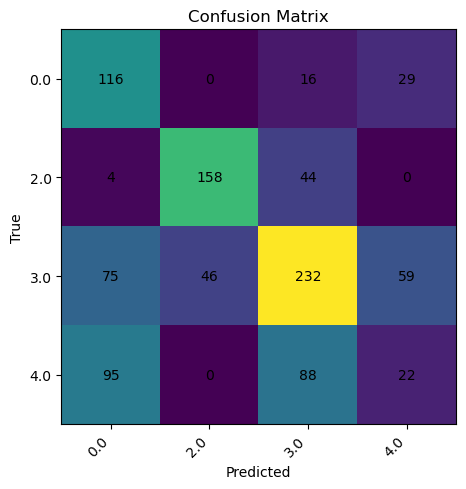

In [87]:
model.eval()
with torch.no_grad():
    logits = model(X_test_t)
probs = torch.softmax(logits, dim=1).cpu().numpy()
pred_labels = probs.argmax(axis=1)
y_true = y_test_t.cpu().numpy()


acc = accuracy_score(y_true, pred_labels)

print(f"Accuracy: {acc:.4f}")

target_names = list(label_encoder.classes_)

# Confusion matrix
cm = confusion_matrix(y_true, pred_labels)
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=np.arange(len(target_names)), labels=target_names, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(target_names)), labels=target_names)
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.tight_layout()
plt.show()
